In [468]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [469]:
label = 'aggregated-ns'
clabel = 'avg.'

label = 'aggregated'
clabel = 'avg.'

label = 'single'
clabel = ''

In [470]:
data = pd.read_csv(f'processed-{label}.csv')

In [471]:
data.columns

Index(['Unnamed: 0', 'dataset', 'k', 'acc', 'sens', 'spec', 'auc', 'best_acc',
       'best_sens', 'best_spec', 'threshold', 'best_threshold',
       'best_acc_orig', 'p', 'n', 'auc_min', 'auc_min_best', 'auc_rmin',
       'auc_rmin_best', 'auc_amin', 'auc_amin_best', 'auc_armin',
       'auc_armin_best', 'auc_max', 'auc_max_best', 'auc_amax',
       'auc_amax_best', 'auc_maxa', 'auc_maxa_best', 'acc_min', 'acc_rmin',
       'acc_max', 'acc_rmax', 'max_acc_min', 'max_acc_max', 'max_acc_rmax'],
      dtype='object')

In [472]:
def convert(x):
    try:
        return float(x)
    except:
        return None

In [473]:
data['auc_min_max'] = (data['auc_min'].apply(convert) + data['auc_max'].apply(convert)) / 2.0
data['auc_rmin_max'] = (data['auc_rmin'].apply(convert) + data['auc_max'].apply(convert)) / 2.0

data['auc_min_max_best'] = (data['auc_min_best'].apply(convert) + data['auc_max_best'].apply(convert)) / 2.0
data['auc_rmin_max_best'] = (data['auc_rmin_best'].apply(convert) + data['auc_max_best'].apply(convert)) / 2.0

data['auc_min_maxa_best'] = (data['auc_min_best'].apply(convert) + data['auc_maxa_best'].apply(convert)) / 2.0
data['auc_rmin_maxa_best'] = (data['auc_rmin_best'].apply(convert) + data['auc_maxa_best'].apply(convert)) / 2.0

data['max_acc_min_max'] = (data['max_acc_min'].apply(convert) + data['max_acc_max'].apply(convert)) / 2.0
data['max_acc_min_rmax'] = (data['max_acc_min'].apply(convert) + data['max_acc_rmax'].apply(convert)) / 2.0

In [475]:
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

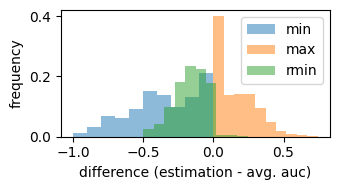

In [476]:
plt.figure(figsize=(3.5, 2))
plt.hist(data['auc_min'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='min')
plt.hist(data['auc_max'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='max')
plt.hist((data['auc_rmin'] - data['auc']).dropna(), weights=np.repeat(1.0/len(data['auc_rmin'].dropna()), len(data['auc_rmin'].dropna())), alpha=0.5, label='rmin')
plt.xlabel(f'difference (estimation - {clabel} auc)')
plt.ylabel('frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}-auc-diffs-hist.pdf')

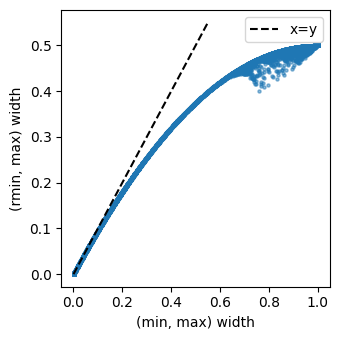

In [477]:
valx = (data['auc_max'] - data['auc_min']).max()*1.1
valy = (data['auc_max'] - data['auc_rmin']).max()*1.1

plt.figure(figsize=(3.5, 3.5))
plt.scatter(data['auc_max'] - data['auc_min'], 
            data['auc_max'] - data['auc_rmin'], 
            alpha=0.5, 
            s=5,
            #label='(min, max) vs. (rmin, max)'
            )
plt.plot([0, min(valx, valy)], [0, min(valx, valy)], label='x=y', c='black', linestyle='--')
plt.xlabel(r'(min, max) width')
plt.ylabel(r'(rmin, max) width')
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}-auc-interval-scatter.pdf')

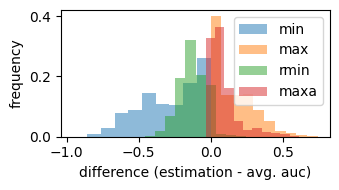

In [478]:
plt.figure(figsize=(3.5, 2))
plt.hist(data['auc_min_best'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='min')
plt.hist(data['auc_max_best'] - data['auc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='max')
plt.hist((data['auc_rmin_best'] - data['auc']).dropna(), weights=np.repeat(1.0/len(data['auc_rmin_best'].dropna()), len(data['auc_rmin_best'].dropna())), alpha=0.5, label='rmin')
plt.hist((data['auc_maxa_best'] - data['auc']).dropna(), weights=np.repeat(1.0/len(data['auc_maxa_best'].dropna()), len(data['auc_maxa_best'].dropna())), alpha=0.5, label='maxa')
plt.xlabel(f'difference (estimation - {clabel} auc)')
plt.ylabel('frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}-auc-macc-diffs-hist.pdf')

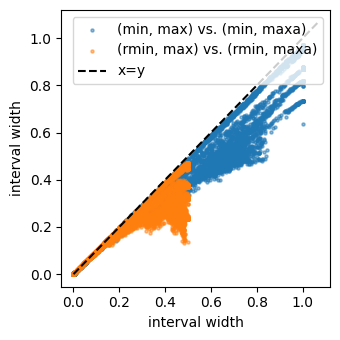

In [479]:
valx = (data['auc_max_best'] - data['auc_min_best']).max()*1.1
valy = (data['auc_maxa_best'] - data['auc_min_best']).max()*1.1

plt.figure(figsize=(3.5, 3.5))
plt.scatter(data['auc_max_best'] - data['auc_min_best'], 
            data['auc_maxa_best'] - data['auc_min_best'], 
            alpha=0.5, 
            s=5,
            label='(min, max) vs. (min, maxa)'
            )
plt.scatter(data['auc_max_best'] - data['auc_rmin_best'], 
            data['auc_maxa_best'] - data['auc_rmin_best'], 
            alpha=0.5, 
            s=5,
            label='(rmin, max) vs. (rmin, maxa)'
            )
plt.plot([0, min(valx, valy)], [0, min(valx, valy)], label='x=y', c='black', linestyle='--')
plt.xlabel(r'interval width')
plt.ylabel(r'interval width')
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}-auc-macc-interval-scatter.pdf')

In [480]:
data.columns

Index(['Unnamed: 0', 'dataset', 'k', 'acc', 'sens', 'spec', 'auc', 'best_acc',
       'best_sens', 'best_spec', 'threshold', 'best_threshold',
       'best_acc_orig', 'p', 'n', 'auc_min', 'auc_min_best', 'auc_rmin',
       'auc_rmin_best', 'auc_amin', 'auc_amin_best', 'auc_armin',
       'auc_armin_best', 'auc_max', 'auc_max_best', 'auc_amax',
       'auc_amax_best', 'auc_maxa', 'auc_maxa_best', 'acc_min', 'acc_rmin',
       'acc_max', 'acc_rmax', 'max_acc_min', 'max_acc_max', 'max_acc_rmax',
       'auc_min_max', 'auc_rmin_max', 'auc_min_max_best', 'auc_rmin_max_best',
       'auc_min_maxa_best', 'auc_rmin_maxa_best', 'max_acc_min_max',
       'max_acc_min_rmax'],
      dtype='object')

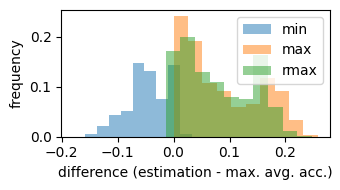

In [481]:
plt.figure(figsize=(3.5, 2))
plt.hist(data['max_acc_min'] - data['best_acc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='min')
plt.hist(data['max_acc_max'] - data['best_acc'], weights=np.repeat(1.0/len(data), len(data)), alpha=0.5, label='max')
plt.hist((data['max_acc_rmax'] - data['best_acc']).dropna(), weights=np.repeat(1.0/len(data['max_acc_rmax'].dropna()), len(data['max_acc_rmax'].dropna())), alpha=0.5, label='rmax')
plt.xlabel(f'difference (estimation - max. {clabel} acc.)')
plt.ylabel('frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}-max-acc-diffs-hist.pdf')

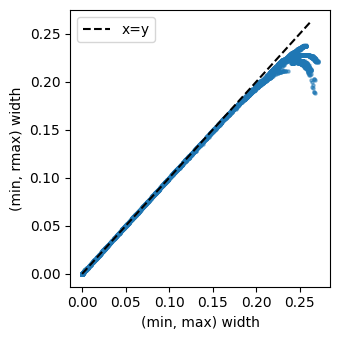

In [482]:
valx = (data['max_acc_max'] - data['max_acc_min']).max()*1.1
valy = (data['max_acc_rmax'] - data['max_acc_min']).max()*1.1
plt.figure(figsize=(3.5, 3.5))
plt.scatter(data['max_acc_max'] - data['max_acc_min'], 
            data['max_acc_rmax'] - data['max_acc_min'], 
            alpha=0.5, 
            s=5,
            #label='(min, max) vs. (min, rmax)'
            )
plt.plot([0, min(valx, valy)], [0, min(valx, valy)], label='x=y', c='black', linestyle='--')
plt.xlabel(r'(min, max) width')
plt.ylabel(r'(min, rmax) width')
plt.legend()
plt.tight_layout()
plt.savefig(f'{label}-max-acc-interval-scatter.pdf')